<a href="https://colab.research.google.com/github/kekayan/pytorch-nlp/blob/main/1_simple_nlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A fixed window toy neural language model with toy datasets


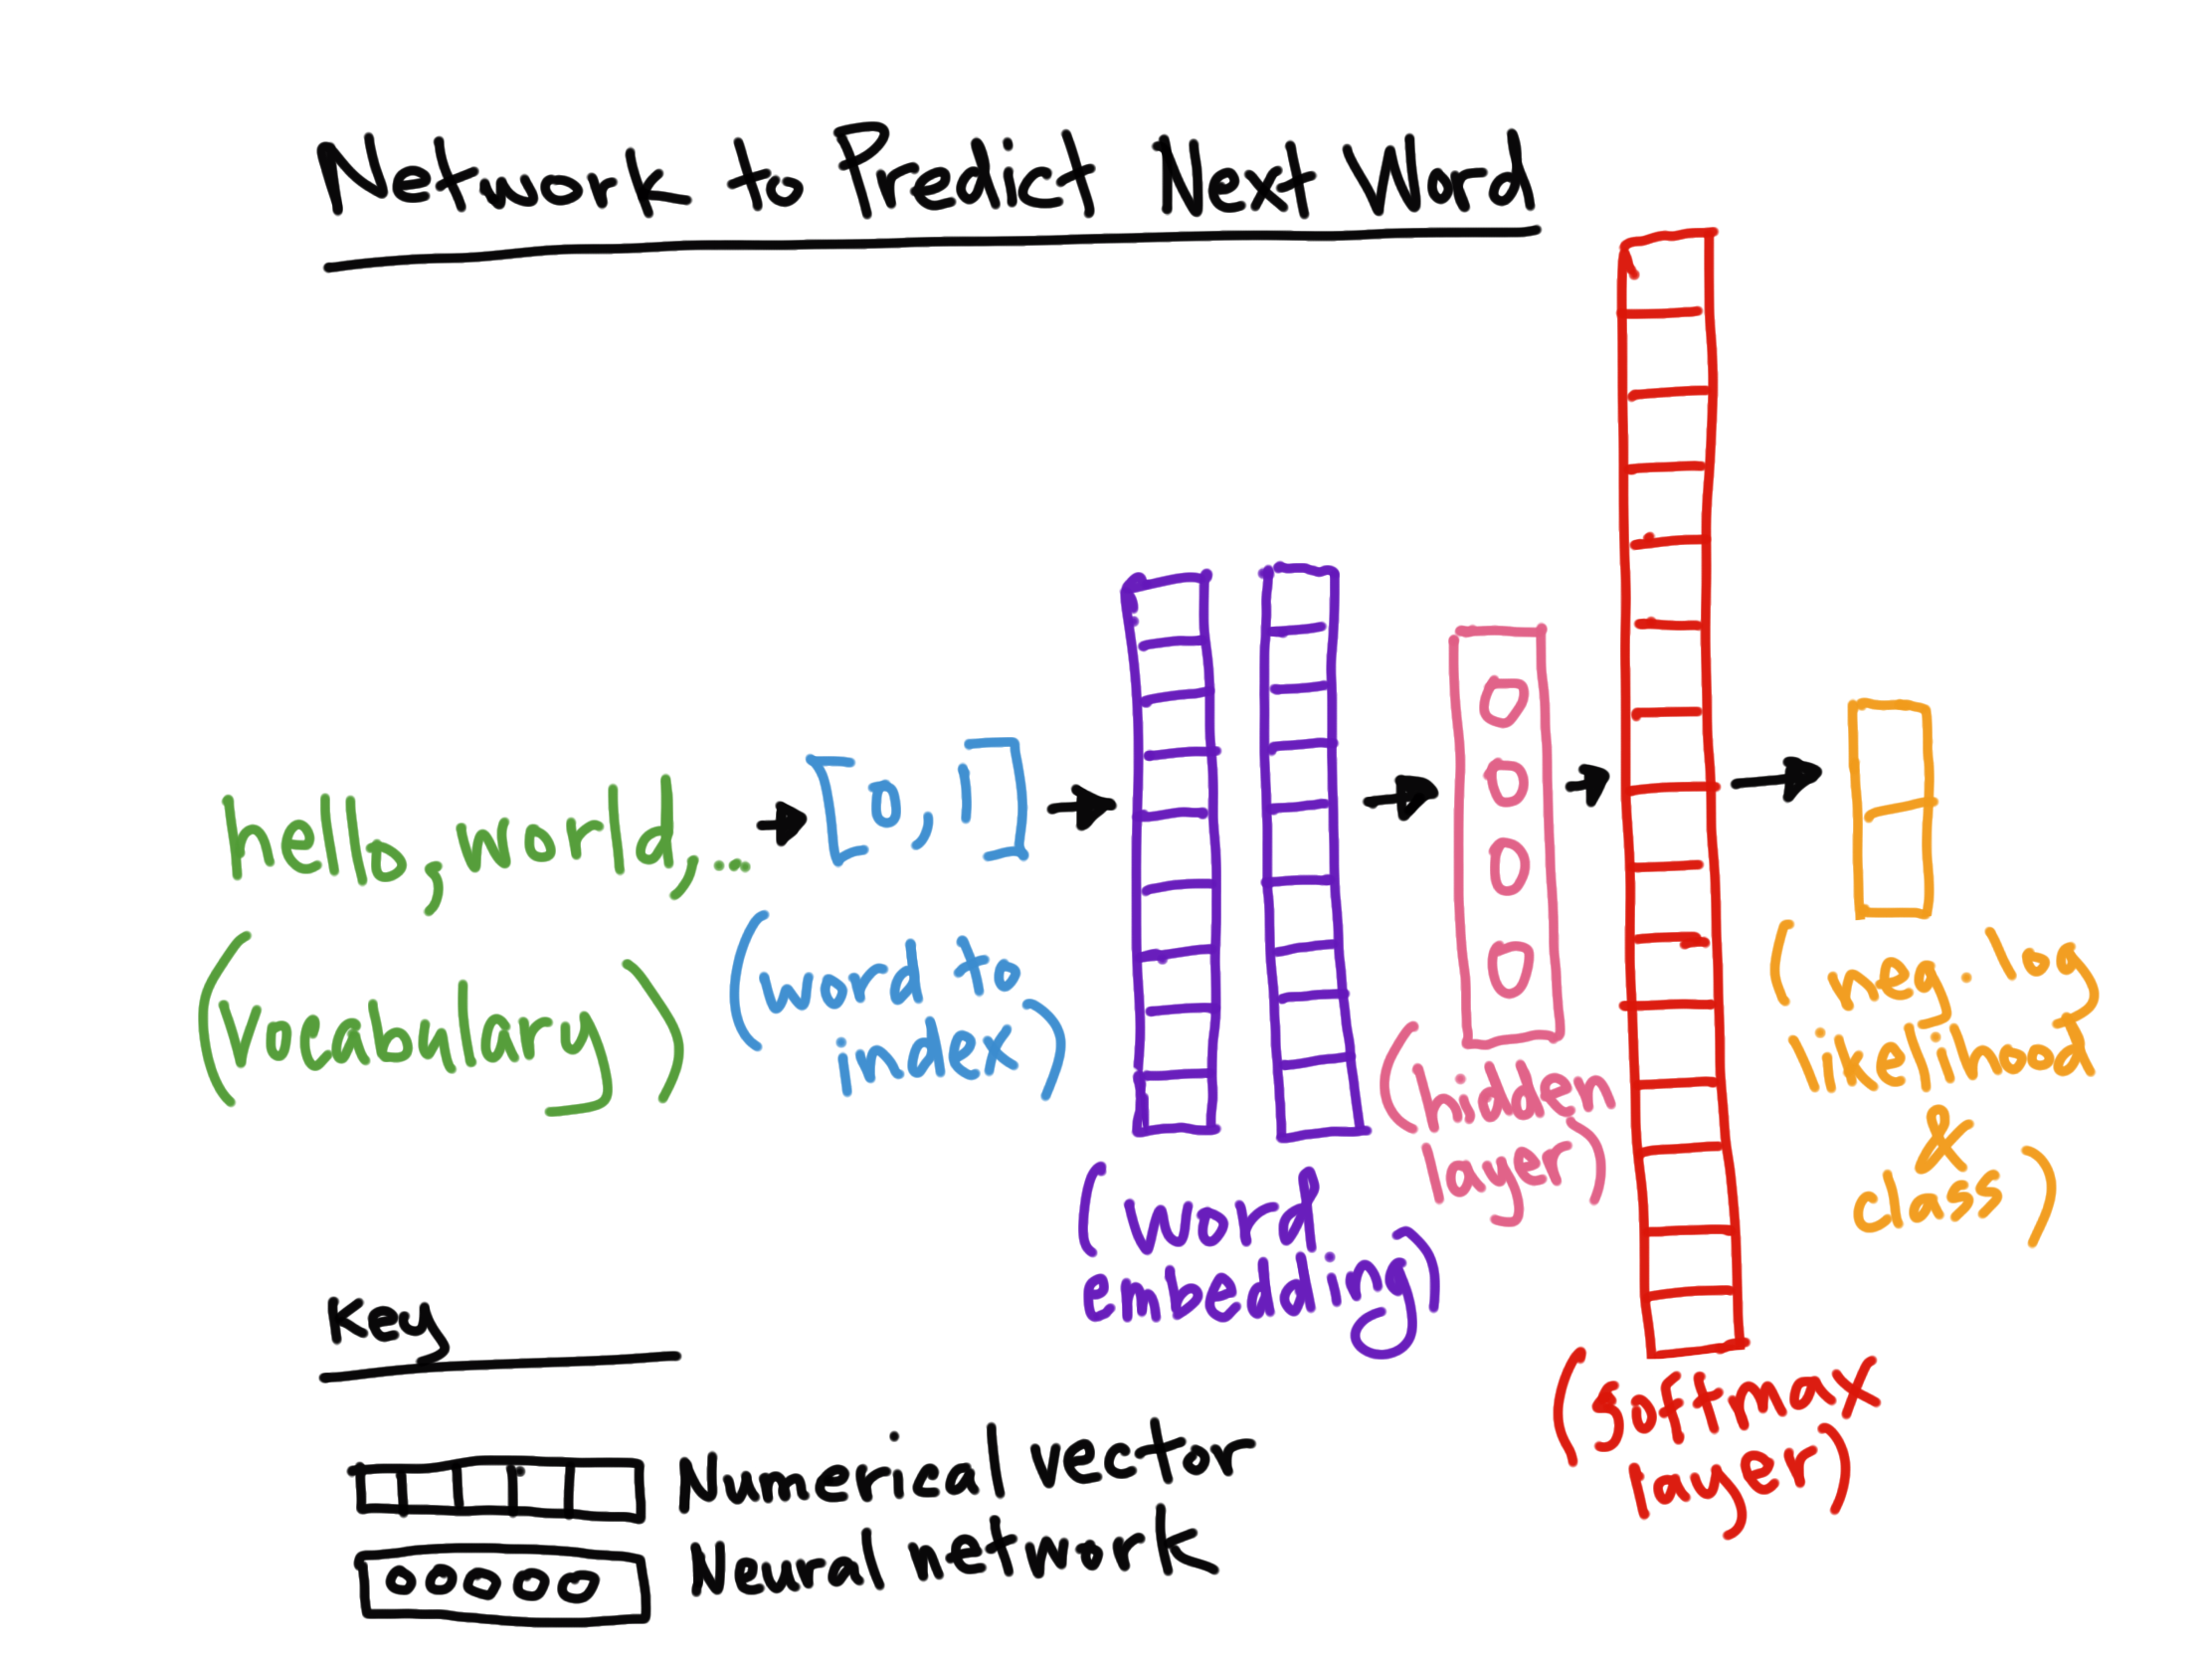

In [ ]:
# toy dataset
sentences= ["nlp is fun", "alice is fast", "let's have fun", "i love chocolates" ]

In [ ]:
# given the first two words of each sentence.
# Let's predict the third word using a fixed window NLM 
# example: given nlp is -> predict - fun

# 1. tokenize our input (sentences)
# 2. convert word to indecies : (nlp: 0)
# 3. reverse vocab (0:nlp)

vocab = {} # map from word type to index
inputs = [] # store indexified version of each sentence


for sent in sentences:
  sent_indexes = []
  words = sent.split() # tokenize by white space
  for word in words:
    if word not in vocab:
      vocab[word] = len(vocab) # add new word type to vocab
    
    sent_indexes.append(vocab[word])
  inputs.append(sent_indexes)

reverse_vocab= {v:k for k,v in vocab.items()}


In [ ]:
print(vocab)
print(reverse_vocab)
# print nlp is fun as idx
print(inputs[0])

{'nlp': 0, 'is': 1, 'fun': 2, 'alice': 3, 'fast': 4, "let's": 5, 'have': 6, 'i': 7, 'love': 8, 'chocolates': 9}
{0: 'nlp', 1: 'is', 2: 'fun', 3: 'alice', 4: 'fast', 5: "let's", 6: 'have', 7: 'i', 8: 'love', 9: 'chocolates'}
[0, 1, 2]


In [ ]:
# prepare our data 
# 1. convert to LongTensors - (cross entropy)
# 2. define inputs / outputs
# our inputs will be first to words indecies  nlp is - [0,1]
# our output is 3rd word index fun -2
import torch
prefixes = torch.LongTensor([sent[:-1] for sent in inputs])
labels = torch.LongTensor([sent[-1] for sent in inputs])

In [ ]:
prefixes,labels

(tensor([[0, 1],
         [3, 1],
         [5, 6],
         [7, 8]]), tensor([2, 4, 2, 9]))

In [ ]:
import torch.nn as nn

class NLM(nn.Module):
    # two things that you need to do
    # 1. init function (initializes all the **parameters** of the network)
    # 2. forward function (defines the forward propagation computations)
  def __init__(self,d_embedding, d_hidden, window_size, len_vocab):
    super().__init__() # init base Module 
    self.d_embedding = d_embedding

    self.embeddings = nn.Embedding(len_vocab, self.d_embedding)

    # concatenated embeddings > hidden
    self.W_hid = nn.Linear(self.d_embedding*window_size, d_hidden)

    # hidden > output probability distribution over vocab
    self.W_out = nn.Linear(d_hidden, len_vocab)


  def forward(self,input):
    batch_size, window_size = input.size()

    embs = self.embeddings(input) # 4, 2, 5
    # print('embedding size:', embs.size())

    # next,  we want to concatenate the prefix embeddings together
    concat_embs = embs.view(batch_size, window_size * self.d_embedding)
    # print('concatenated embs size:', concat_embs.size())

    # now, we project this to the hidden space
    hiddens = self.W_hid(concat_embs)
    # print('hidden size:', hiddens.size())

    # finally, project hiddens to vocabulary space
    outs = self.W_out(hiddens)
    # print('output size:', outs.size())


    return outs # return unnormalized probability, also known as **logits**
    

network = NLM(d_embedding=5, d_hidden=12, window_size=2, len_vocab=len(vocab))

In [ ]:
num_epochs = 100 # how many times we are going to go through our entire training dataset
learning_rate = 0.1 # we can modify this if training isn't converging, etc.
loss_fn = nn.CrossEntropyLoss() # average cross entropy loss over each prefix in batch

# we will use vanilla gradient descent, you can experiment with others like Adam
optimizer = torch.optim.SGD(params=network.parameters(), lr=learning_rate)

for i in range(num_epochs):
  logits = network(prefixes)
  loss = loss_fn(logits,labels)
  # now let's update our params to make the loss smaller
  # step 1: compute gradient (partial derivs of loss WRT parameters)
  loss.backward()

  # step 2: update params using gradient descent
  optimizer.step()

  # step 3: zero out the gradients for the next epoch
  optimizer.zero_grad()
  print('epoch: %d, loss: %0.2f' % (i, loss))


epoch: 0, loss: 2.20
epoch: 1, loss: 2.00
epoch: 2, loss: 1.82
epoch: 3, loss: 1.65
epoch: 4, loss: 1.49
epoch: 5, loss: 1.34
epoch: 6, loss: 1.20
epoch: 7, loss: 1.07
epoch: 8, loss: 0.95
epoch: 9, loss: 0.84
epoch: 10, loss: 0.75
epoch: 11, loss: 0.66
epoch: 12, loss: 0.58
epoch: 13, loss: 0.51
epoch: 14, loss: 0.44
epoch: 15, loss: 0.39
epoch: 16, loss: 0.34
epoch: 17, loss: 0.30
epoch: 18, loss: 0.26
epoch: 19, loss: 0.23
epoch: 20, loss: 0.21
epoch: 21, loss: 0.18
epoch: 22, loss: 0.16
epoch: 23, loss: 0.15
epoch: 24, loss: 0.14
epoch: 25, loss: 0.12
epoch: 26, loss: 0.11
epoch: 27, loss: 0.10
epoch: 28, loss: 0.10
epoch: 29, loss: 0.09
epoch: 30, loss: 0.08
epoch: 31, loss: 0.08
epoch: 32, loss: 0.07
epoch: 33, loss: 0.07
epoch: 34, loss: 0.06
epoch: 35, loss: 0.06
epoch: 36, loss: 0.06
epoch: 37, loss: 0.05
epoch: 38, loss: 0.05
epoch: 39, loss: 0.05
epoch: 40, loss: 0.05
epoch: 41, loss: 0.04
epoch: 42, loss: 0.04
epoch: 43, loss: 0.04
epoch: 44, loss: 0.04
epoch: 45, loss: 0.0

In [ ]:
# our loss has dropped to close to 0.
# but is it actually working? let's see

# let's first define a reverse vocabulary mapping (idx>word type)
rev_vocab = dict((idx, word) for (word, idx) in vocab.items())
boblikes = prefixes[0].unsqueeze(0)
logits = network(boblikes)
probs = nn.functional.softmax(logits, dim=1).squeeze()
argmax_idx = torch.argmax(probs).item()
print('given "nlp is", the model predicts "%s" with %0.4f probability' % (rev_vocab[argmax_idx], probs[argmax_idx]))

given "nlp is", the model predicts "fun" with 0.9917 probability
